# Download the RSNA dataset
- RSNA Pneumonia Detection Challenge for predicting whether pneumonia exists in a given image.
- first download the kaggle, follow commands below:
```
cd ~/datasets/
mkdir rsna
cd rsna
kaggle competitions download -c rsna-pneumonia-detection-challenge
unzip rsna-pneumonia-detection-challenge.zip

```


## Preprocess for classfication/detection.
- orinial rsna annotations, if for each brounding box, change the annotations for each image
- first change the boungdingbox x,y,w,h->x1,y1,x2,y2
- aggregate multiple boxes into one patient.
- group by pateint. 
- make label of patient-level, if have boundingbox, unhealthy:1, otherwise healthy:0
- len of annotations: 30227->26684, because change to pateint level

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
from tqdm import tqdm

In [2]:
dataset_folder = '../../datasets/rsna'
image_folder = f'{dataset_folder}/stage_2_train_images'
annotations = 'stage_2_train_labels.csv'

#load dataa
df = pd.read_csv(f'{dataset_folder}/{annotations}')
print('original-df len:', len(df))
df

original-df len: 30227


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [3]:
def create_bbox(row):
    """
        Create bounding boxes (x1, y1, x2, y2)
    """
    if row["Target"] == 0:
        return [0.0, 0.0, 0.0, 0.0]  # Healthy case, bbox is [0, 0, 0, 0]
    else:
        x1 = row["x"]
        y1 = row["y"]
        x2 = x1 + row["width"]
        y2 = y1 + row["height"]
        return [x1, y1, x2, y2]

In [4]:
df["bbox"] = df.apply(lambda x: create_bbox(x), axis=1)

In [5]:
df.head()

,patientId,x,y,width,height,Target,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,"[0.0, 0.0, 0.0, 0.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,"[0.0, 0.0, 0.0, 0.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,"[0.0, 0.0, 0.0, 0.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[0.0, 0.0, 0.0, 0.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 477.0, 531.0]"


In [6]:
# Aggregate multiple bounding boxes by patientId
df = df[["patientId", "bbox"]]
df = df.groupby("patientId").agg(list)
df = df.reset_index()
len(df)

26684

In [7]:
df["Target"] = df["bbox"].apply(lambda x: 0 if x == [[0.0, 0.0, 0.0, 0.0]] else 1)  #set to healthy (0) if bbox is [0, 0, 0, 0]

In [8]:
df.head()

,patientId,bbox,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[0.0, 0.0, 0.0, 0.0]]",0
1,000924cf-0f8d-42bd-9158-1af53881a557,"[[0.0, 0.0, 0.0, 0.0]]",0
2,000db696-cf54-4385-b10b-6b16fbb3f985,"[[316.0, 318.0, 486.0, 796.0], [660.0, 375.0, ...",1
3,000fe35a-2649-43d4-b027-e67796d412e0,"[[570.0, 282.0, 839.0, 691.0], [83.0, 227.0, 3...",1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,"[[66.0, 160.0, 439.0, 768.0], [552.0, 164.0, 9...",1


In [9]:
# Add file path to df
df["path"] = df["patientId"].apply(lambda x: f"{image_folder}/{x}.dcm")
df.columns

Index(['patientId', 'bbox', 'Target', 'path'], dtype='object')

In [10]:
print(df.isnull().sum())

patientId    0
bbox         0
Target       0
path         0
dtype: int64


### Data Set Check

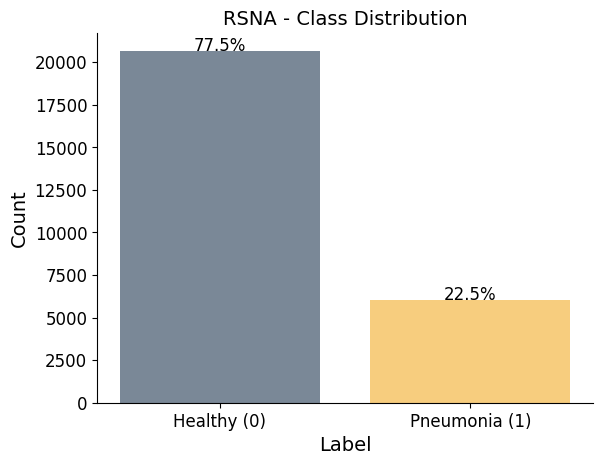

In [11]:
# analyse target column
class_counts = df['Target'].value_counts()
total = class_counts.sum()
percentages = (class_counts / total) * 100

#plot
colors = ['#7A8897', '#F7CD7E']

bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xticks([0, 1], labels=['Healthy (0)', 'Pneumonia (1)'], fontsize=14)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('RSNA - Class Distribution', fontsize=14)

# Add percentages on top of bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 15,
             f'{percentage:.1f}%', ha='center', fontsize=12, color='black')
sns.despine(top=True, right=True)
#plt.savefig("rsna.pdf", format="pdf", dpi=300)
plt.show()

In [12]:
# Split the dataset
test_fac = 0.15 #scaling factor --> 70, 15, 15
train_df, test_val_df = train_test_split(df, test_size=test_fac * 2, random_state=0)
test_df, valid_df = train_test_split(test_val_df, test_size=0.5, random_state=0)

print(f"Number of train samples: {len(train_df)}")
print(f"Number of valid samples: {len(valid_df)}")
print(f"Number of test samples: {len(test_df)}")

Number of train samples: 18678
Number of valid samples: 4003
Number of test samples: 4003


In [13]:
# Rename Target col
train_df.rename(columns={"Target": "label"}, inplace=True)
valid_df.rename(columns={"Target": "label"}, inplace=True)
test_df.rename(columns={"Target": "label"}, inplace=True)

print(train_df.columns)

Index(['patientId', 'bbox', 'label', 'path'], dtype='object')


In [14]:
#csv paths
RSNA_TRAIN_CSV = '../annotations/rsna/train.csv'
RSNA_VALID_CSV = '../annotations/rsna/val.csv'
RSNA_TEST_CSV = '../annotations/rsna/test.csv'

train_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TRAIN_CSV, index=False)
valid_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_VALID_CSV, index=False)
test_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TEST_CSV, index=False)

print(f'Train CSV saved to: {RSNA_TRAIN_CSV}')
print(f'Valid CSV saved to: {RSNA_VALID_CSV}')
print(f'Test CSV saved to: {RSNA_TEST_CSV}')

Train CSV saved to: ../annotations/rsna/train.csv
Valid CSV saved to: ../annotations/rsna/val.csv
Test CSV saved to: ../annotations/rsna/test.csv


Absolute counts per split:
Train:
  Healthy (0): 14516
  Pneumonia (1): 4162

Validation:
  Healthy (0): 3075
  Pneumonia (1): 928

Test:
  Healthy (0): 3081
  Pneumonia (1): 922



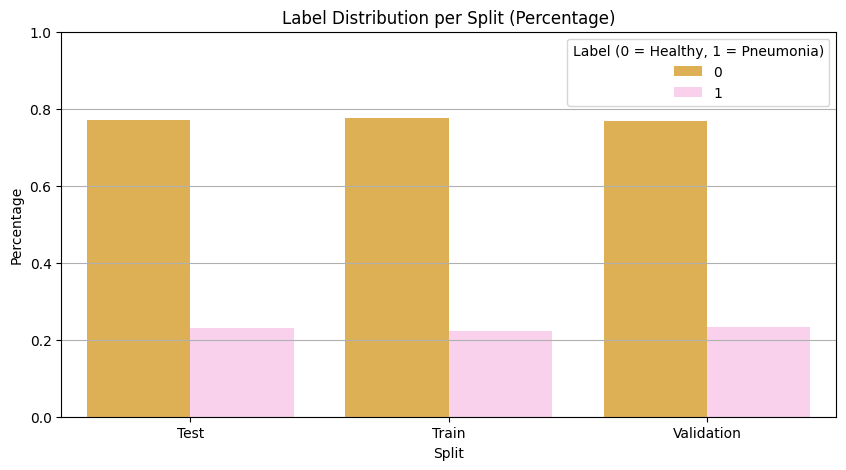

In [16]:
# plot the class distributions across the splits
splits = {
    'Train': train_df['label'],
    'Validation': valid_df['label'],
    'Test': test_df['label']
}

print("Absolute counts per split:")
for name, labels in splits.items():
    counts = labels.value_counts().sort_index()
    print(f"{name}:")
    for label, count in counts.items():
        label_name = "Healthy (0)" if label == 0 else "Pneumonia (1)"
        print(f"  {label_name}: {count}")
    print()


plot_df = pd.concat([
    pd.DataFrame({'Split': split, 'Label': labels})
    for split, labels in splits.items()
])

# Compute percentage
percent_df = (
    plot_df.groupby('Split')['Label']
    .value_counts(normalize=True)
    .rename('Percentage')
    .reset_index()
)

#plot
colors = ['#F4B73F', '#FFCBEF'] 
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=percent_df,
    x='Split',
    y='Percentage',
    hue='Label',
    palette={0: colors[0], 1: colors[1]}  
)
plt.title('Label Distribution per Split (Percentage)')
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.legend(title='Label (0 = Healthy, 1 = Pneumonia)', loc='upper right')
plt.grid(axis='y')
plt.show()

### Image Sanity Check

In [17]:
#get one sample
sample_path = df[df['Target'] == 1]['path'].iloc[0] 
ds = pydicom.dcmread(sample_path)
print(f"Image shape: {ds.pixel_array.shape}")

Image shape: (1024, 1024)


In [18]:
#check if all have the same size
sizes = []
for path in df['path'].sample(100):
    ds = pydicom.dcmread(path)
    sizes.append(ds.pixel_array.shape)

pd.Series(sizes).value_counts()

(1024, 1024)    100
Name: count, dtype: int64

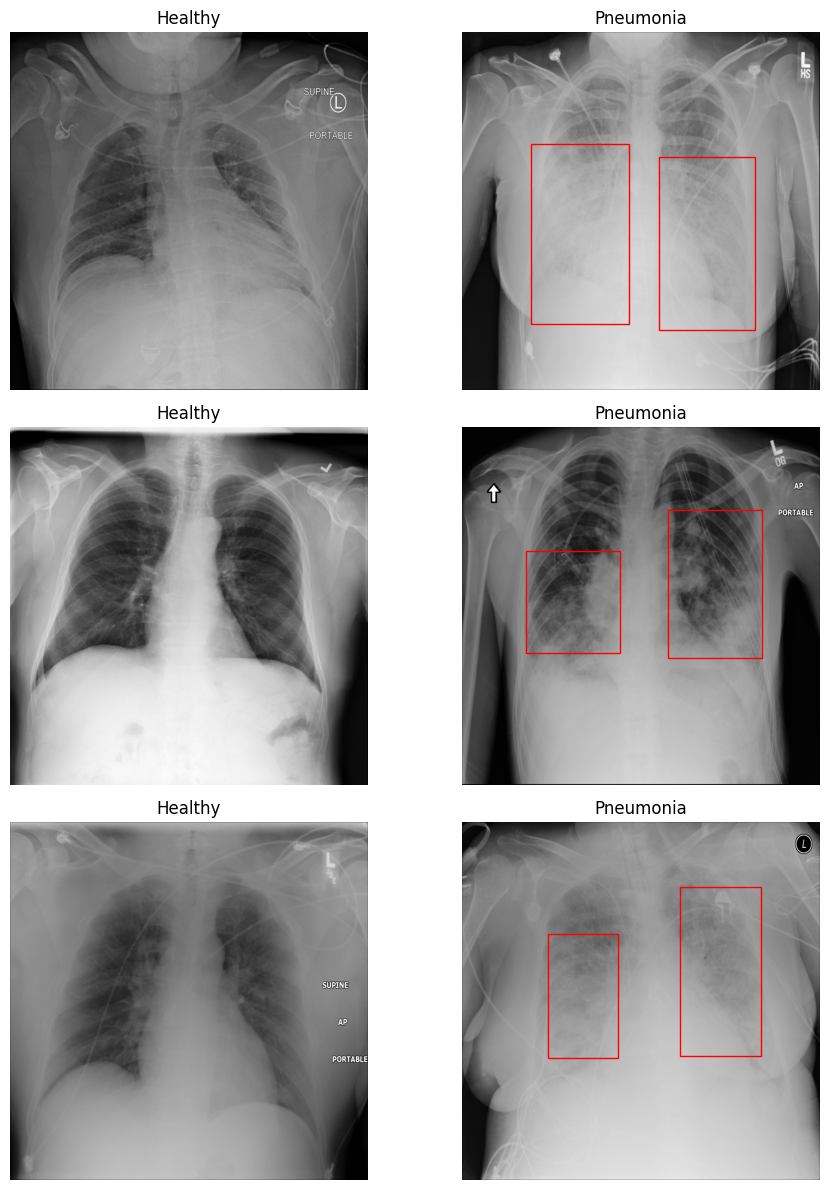

In [19]:
#plot some images
def show_image(path, bbox=None, title=""):
    ds = pydicom.dcmread(path)
    plt.imshow(ds.pixel_array, cmap='gray')
    if bbox:
        if isinstance(bbox[0], list):  # multiple boxes
            for b in bbox:
                x1, y1, x2, y2 = b
                w, h = x2 - x1, y2 - y1
                rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
        else:  # single box
            x1, y1, x2, y2 = bbox
            w, h = x2 - x1, y2 - y1
            rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.title(title)
    plt.axis('off')


#healthy and pneumonia samples
healthy_samples = df[df['Target'] == 0].sample(3, random_state=42)
pneumonia_samples = df[df['Target'] == 1].sample(3, random_state=42)

#plot
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
    # Healthy left
    plt.sca(axes[i, 0])
    show_image(healthy_samples.iloc[i]['path'], title='Healthy')

    # Pneumonia right
    plt.sca(axes[i, 1])
    show_image(pneumonia_samples.iloc[i]['path'], bbox=pneumonia_samples.iloc[i]['bbox'], title='Pneumonia')

plt.tight_layout()
plt.show()

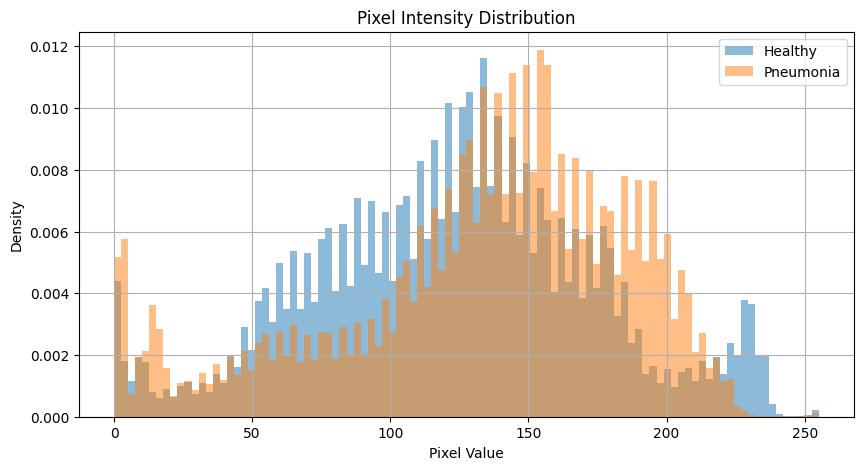

In [20]:
#is there a distribution shift --> example for those three
def get_pixel_values(path):
    ds = pydicom.dcmread(path)
    return ds.pixel_array.flatten()

healthy_pixels = np.concatenate([get_pixel_values(p) for p in healthy_samples['path']])
pneumonia_pixels = np.concatenate([get_pixel_values(p) for p in pneumonia_samples['path']])

plt.figure(figsize=(10, 5))
plt.hist(healthy_pixels, bins=100, alpha=0.5, label='Healthy', density=True)
plt.hist(pneumonia_pixels, bins=100, alpha=0.5, label='Pneumonia', density=True)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Loading healthy validation images...


100%|███████████████████████████████████████| 3075/3075 [09:30<00:00,  5.39it/s]


Loading pneumonia validation images...


100%|█████████████████████████████████████████| 928/928 [03:28<00:00,  4.45it/s]


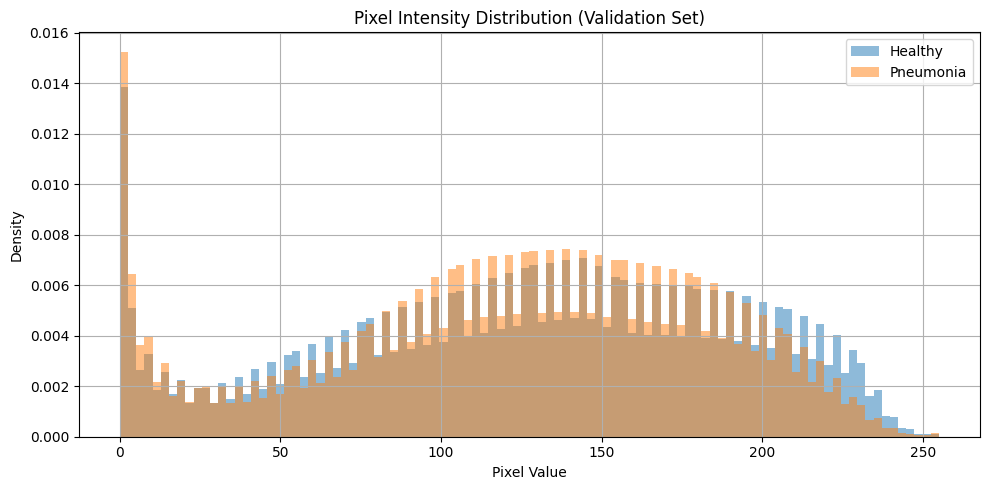

In [21]:
#Check intensity for samples of validation set (since ALL samples is too comp. heavy)

# extract pixel values from DICOM
def get_pixel_values(path):
    ds = pydicom.dcmread(path)
    return ds.pixel_array.flatten()

#use validation set
val_healthy_paths = valid_df[valid_df['label'] == 0]['path']
val_pneumonia_paths = valid_df[valid_df['label'] == 1]['path']


healthy_pixels = []
pneumonia_pixels = []

print("Loading healthy validation images...")
for path in tqdm(val_healthy_paths):
    healthy_pixels.append(get_pixel_values(path))

print("Loading pneumonia validation images...")
for path in tqdm(val_pneumonia_paths):
    pneumonia_pixels.append(get_pixel_values(path))

healthy_pixels = np.concatenate(healthy_pixels)
pneumonia_pixels = np.concatenate(pneumonia_pixels)

#plot
plt.figure(figsize=(10, 5))
plt.hist(healthy_pixels, bins=100, alpha=0.5, label='Healthy', density=True)
plt.hist(pneumonia_pixels, bins=100, alpha=0.5, label='Pneumonia', density=True)
plt.title('Pixel Intensity Distribution (Validation Set)')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Bounding Box analysis

Bounding box count stats per unhealthy patient:
count    6012.000000
mean        1.589321
std         0.542800
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: num_boxes, dtype: float64


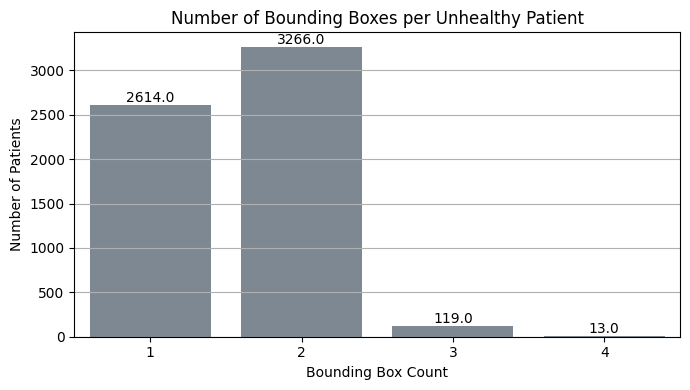

In [22]:
#show bounding box statistics

unhealthy_df = df[df['Target'] == 1].copy()

# Count bbx per patient
unhealthy_df['num_boxes'] = unhealthy_df['bbox'].apply(len)

print("Bounding box count stats per unhealthy patient:")
print(unhealthy_df['num_boxes'].describe())

#plot
color = '#7A8897'
plt.figure(figsize=(7, 4))
ax = sns.countplot(x='num_boxes', data=unhealthy_df, color=color)

for p in ax.patches: #annotate
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
    
plt.title('Number of Bounding Boxes per Unhealthy Patient')
plt.xlabel('Bounding Box Count')
plt.ylabel('Number of Patients')
plt.xticks([0, 1, 2, 3], [1, 2, 3, 4])  # map positions to actual box counts
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [24]:
#show average bounding box area ÷ total image area

all_boxes = []
for _, row in unhealthy_df.iterrows():
    pid = row['patientId']
    for bbox in row['bbox']:
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        area = w * h

        image_path = df[df['patientId'] == pid]['path'].values[0]
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        image_area = ds.Rows * ds.Columns
        ratio = area / image_area

        all_boxes.append((pid, image_path, (x1, y1, w, h), area, ratio, img))

#compute average ratio
avg_ratio = sum(b[4] for b in all_boxes) / len(all_boxes)
print(f"Average bounding box coverage (all boxes): {avg_ratio:.2%}")

KeyboardInterrupt: 

In [ ]:
#Sort to get smallest and largest bbox
sorted_boxes = sorted(all_boxes, key=lambda x: x[4])
selected = [sorted_boxes[1], sorted_boxes[-1]]  

# Plot a small one and a large one
for pid, _, (x, y, w, h), area, ratio, img in selected:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img, cmap='gray')
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f'Patient: {pid}\nBox Area = {area:.0f} px ({ratio:.2%})')
    ax.axis('off')
    plt.show()

## Balance the data with Undersampling

In [25]:
df.describe()

,Target
count,26684.000000
mean,0.225304
std,0.417790
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [26]:
def balance_classes(df, target_column="Target", sample_size=None):
    min_class_count = df[target_column].value_counts().min()
    sample_size = sample_size or min_class_count

    balanced_df = (
        df.groupby(target_column)
        .apply(lambda x: x.sample(sample_size, replace=len(x) < sample_size, random_state=42))
        .reset_index(drop=True)
    )
    return balanced_df

In [27]:
df_balanced = balance_classes(df, target_column="Target")  # or "label" if renamed
df_balanced

,patientId,bbox,Target,path
0,f8e0ed85-399a-4c57-afc5-a111923d2662,"[[0.0, 0.0, 0.0, 0.0]]",0,../../datasets/rsna/stage_2_train_images/f8e0e...
1,83202eb5-7996-4d24-ad8b-6680d9e98bd2,"[[0.0, 0.0, 0.0, 0.0]]",0,../../datasets/rsna/stage_2_train_images/83202...
2,c7935568-7703-4ffe-8b55-b656cc5bb7bc,"[[0.0, 0.0, 0.0, 0.0]]",0,../../datasets/rsna/stage_2_train_images/c7935...
3,a2cad327-ecaa-4bff-9a4c-7316e784b873,"[[0.0, 0.0, 0.0, 0.0]]",0,../../datasets/rsna/stage_2_train_images/a2cad...
4,e701619c-8f85-4fd2-af6b-0e751d4c561d,"[[0.0, 0.0, 0.0, 0.0]]",0,../../datasets/rsna/stage_2_train_images/e7016...
...,...,...,...,...
12019,a8cb813b-9d3a-46ff-8003-053271cdcc9a,"[[194.0, 164.0, 425.0, 508.0]]",1,../../datasets/rsna/stage_2_train_images/a8cb8...
12020,ce5f8ade-0760-4a40-906d-301cc6bbb87b,"[[536.0, 272.0, 778.0, 661.0], [149.0, 234.0, ...",1,../../datasets/rsna/stage_2_train_images/ce5f8...
12021,d094558c-2614-4d0b-b142-a9de0864f572,"[[110.0, 249.0, 511.0, 809.0], [568.0, 228.0, ...",1,../../datasets/rsna/stage_2_train_images/d0945...
12022,db5399f8-e0cb-4208-8694-a7136f9ac574,"[[378.0, 310.0, 489.0, 440.0]]",1,../../datasets/rsna/stage_2_train_images/db539...


 -> 12024 instead of 26684

### Data Set Check

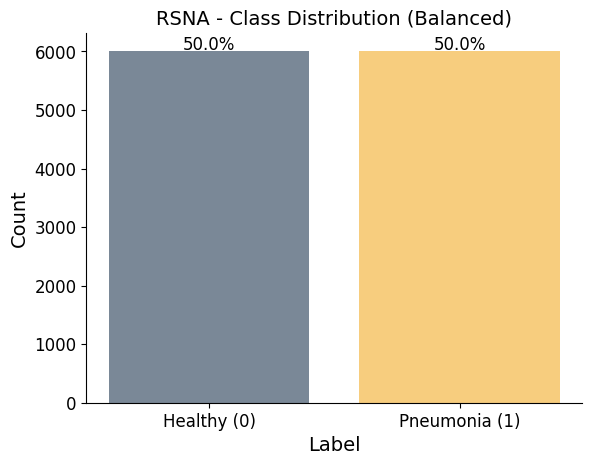

In [28]:
# analyse target column
class_counts_bal = df_balanced['Target'].value_counts()
total_bal = class_counts_bal.sum()
percentages_bal = (class_counts_bal / total_bal) * 100

#plot
colors = ['#7A8897', '#F7CD7E']
bars = plt.bar(class_counts_bal.index, class_counts_bal.values, color=colors)
plt.xticks([0, 1], labels=['Healthy (0)', 'Pneumonia (1)'], fontsize=14)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('RSNA - Class Distribution (Balanced)', fontsize=14)

# Add percentages on top of bars
for bar, percentage in zip(bars, percentages_bal):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 15,
             f'{percentage:.1f}%', ha='center', fontsize=12, color='black')
sns.despine(top=True, right=True)
#plt.savefig("rsna.pdf", format="pdf", dpi=300)
plt.show()

In [29]:
#split also the balanced dataset
test_fac = 0.15
train_bal_df, test_val_bal_df = train_test_split(df_balanced, test_size=test_fac * 2, random_state=0)
test_bal_df, valid_bal_df = train_test_split(test_val_bal_df, test_size=0.5, random_state=0)
valid_bal_df = valid_bal_df.rename(columns={"Target": "label"})

In [30]:
print(f"Number of train samples (balanced): {len(train_bal_df)}")
print(f"Number of valid samples (balanced): {len(valid_bal_df)}")
print(f"Number of test samples (balanced): {len(test_bal_df)}")

# Rename Target col
train_bal_df.rename(columns={"Target": "label"}, inplace=True)
valid_bal_df.rename(columns={"Target": "label"}, inplace=True)
test_bal_df.rename(columns={"Target": "label"}, inplace=True)

print(train_bal_df.columns)

Number of train samples (balanced): 8416
Number of valid samples (balanced): 1804
Number of test samples (balanced): 1804
Index(['patientId', 'bbox', 'label', 'path'], dtype='object')


In [31]:
#csv paths
RSNA_TRAIN_BAL_CSV = '../annotations/rsna/train_balanced.csv'
RSNA_VALID_BAL_CSV = '../annotations/rsna/val_balanced.csv'
RSNA_TEST_BAL_CSV = '../annotations/rsna/test_balanced.csv'

train_bal_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TRAIN_BAL_CSV, index=False)
valid_bal_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_VALID_BAL_CSV, index=False)
test_bal_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TEST_BAL_CSV, index=False)

print(f'Train CSV (balanced) saved to: {RSNA_TRAIN_BAL_CSV}')
print(f'Valid CSV (balanced) saved to: {RSNA_VALID_BAL_CSV}')
print(f'Test CSV (balanced) saved to: {RSNA_TEST_BAL_CSV}')

Train CSV (balanced) saved to: ../annotations/rsna/train_balanced.csv
Valid CSV (balanced) saved to: ../annotations/rsna/val_balanced.csv
Test CSV (balanced) saved to: ../annotations/rsna/test_balanced.csv


Absolute counts per balanced split:
Train:
  Healthy (0): 4242
  Pneumonia (1): 4174

Validation:
  Healthy (0): 890
  Pneumonia (1): 914

Test:
  Healthy (0): 880
  Pneumonia (1): 924



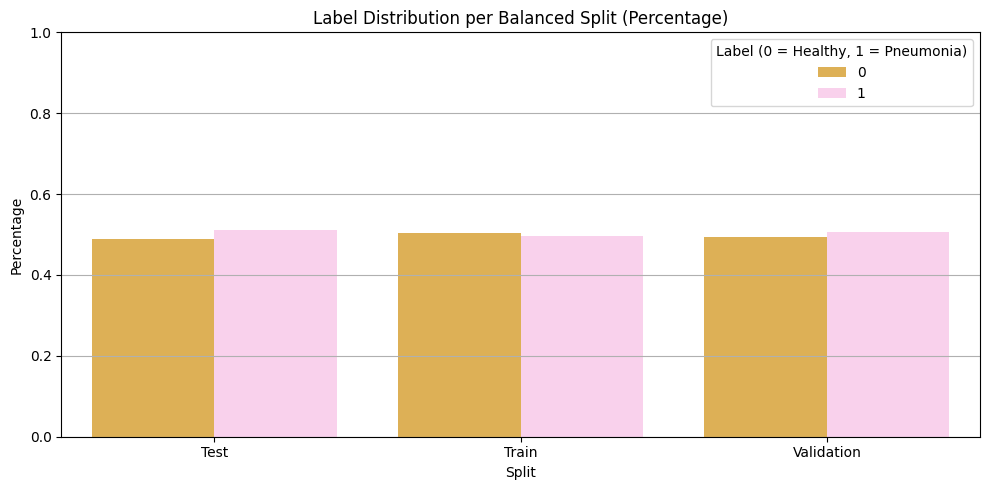

In [32]:
splits_bal = {
    'Train': train_bal_df['label'],
    'Validation': valid_bal_df['label'],
    'Test': test_bal_df['label']
}

print("Absolute counts per balanced split:")  #print text of abs counnt
for name, labels in splits_bal.items():
    counts = labels.value_counts().sort_index()
    print(f"{name}:")
    for label, count in counts.items():
        label_name = "Healthy (0)" if label == 0 else "Pneumonia (1)"
        print(f"  {label_name}: {count}")
    print()

plot_df_bal = pd.concat([
    pd.DataFrame({'Split': split, 'Label': labels})
    for split, labels in splits_bal.items()
])

# Compute percentage
percent_df_bal = (
    plot_df_bal.groupby('Split')['Label']
    .value_counts(normalize=True)
    .rename('Percentage')
    .reset_index()
)

#plot

colors = ['#F4B73F', '#FFCBEF'] 

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=percent_df_bal,
    x='Split',
    y='Percentage',
    hue='Label',
    palette={0: colors[0], 1: colors[1]}  
)
plt.title('Label Distribution per Balanced Split (Percentage)')
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.legend(title='Label (0 = Healthy, 1 = Pneumonia)', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Visualize how much data got lost when undersampling

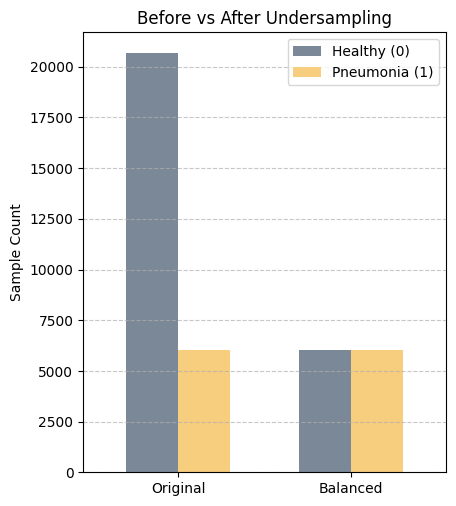

Sample loss due to undersampling:
Label 0: 14660 samples removed (70.9%)
Label 1: 0 samples removed (0.0%)


In [33]:
#counts
original_counts = df['Target'].value_counts().sort_index()
balanced_counts = df_balanced['Target'].value_counts().sort_index()

loss_df = pd.DataFrame({
    'Original': original_counts,
    'Balanced': balanced_counts
}).T

loss_df.columns = ['Healthy (0)', 'Pneumonia (1)']

colors = ['#7A8897', '#F7CD7E']

loss_df.plot(
    kind='bar',
    figsize=(4.5, 5), 
    color=colors,
    width=0.6  
)

plt.title('Before vs After Undersampling', fontsize=12)
plt.ylabel('Sample Count', fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=0.5)  # tighter layout
plt.show()

print("Sample loss due to undersampling:")
for label in [0, 1]:
    orig = original_counts[label]
    bal = balanced_counts[label]
    loss = orig - bal
    percent = (loss / orig) * 100
    print(f"Label {label}: {loss} samples removed ({percent:.1f}%)")

In [34]:
print(f"Original dataset size: {len(df)} samples")
print(f"Balanced dataset size: {len(df_balanced)} samples")
removed = len(df) - len(df_balanced)
percent_removed = (removed / len(df)) * 100
print(f"Samples removed due to undersampling: {removed} ({percent_removed:.1f}%)")

Original dataset size: 26684 samples
Balanced dataset size: 12024 samples
Samples removed due to undersampling: 14660 (54.9%)


- **Undersampling** may not be ideal since a lot of data was lost  
  → ~71% of healthy samples were removed, which can significantly reduce the diversity and richness of the majority class and impair generalization

- **Oversampling** may not be a good alternative due to the high risk of overfitting  
  → Simply duplicating pneumonia samples may lead the model to memorize them rather than learn generalizable features...

- **Class-weighted loss** can be promising
  → By increasing the penalty for misclassifying minority class samples, the model can learn more balanced decision boundaries without altering the data distribution
  → This could be something I could try

- **Data augmentation (for pneumonia only)**
  → Will increases minority class variability by generating realistic variations (e.g., brightness, cropping, noise) without changing the label. Helps prevent overfitting and improves generalization, especially in image data. (but I will need to consider which augemtnations)

- **SMOTE or other synthetic oversampling** can be considered if feature embeddings are available  
  → Not directly applicable to raw image data, but can be applied on extracted features..

- **Anomaly detection framing** could work in extremely imbalanced settings  
  → This is useful if pneumonia class would be extremely rare, but this is not the case here